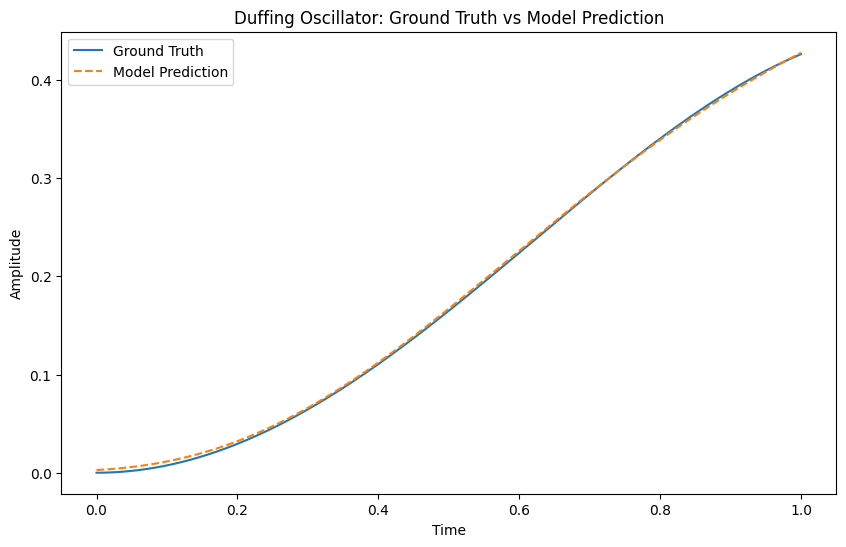

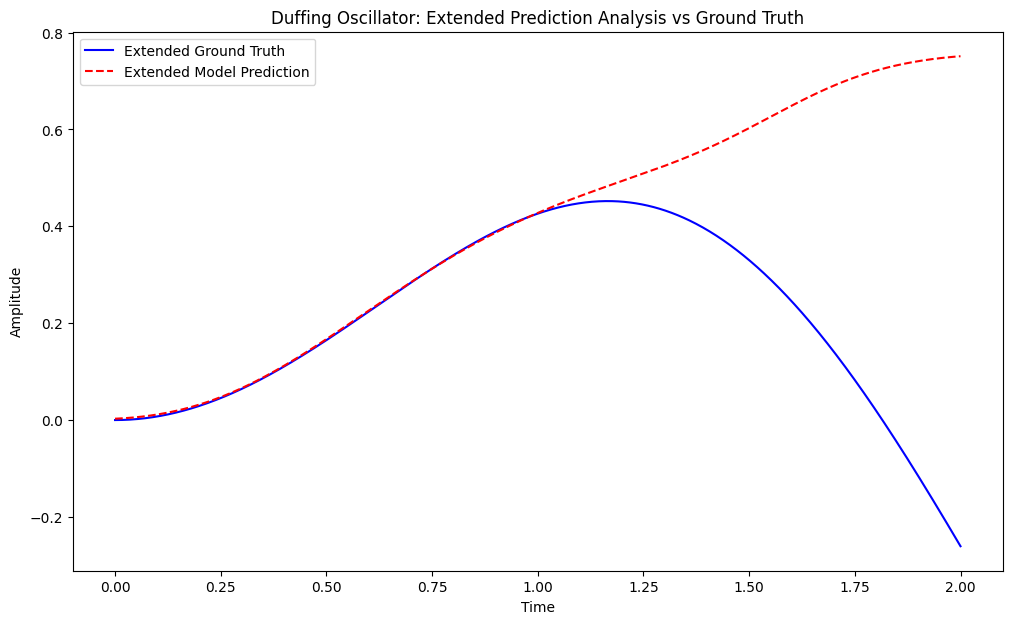

Number of close predictions: 657
Number of close predictions (extended only): 157


In [55]:
import numpy as np
import torch
from scipy.integrate import odeint
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from torch import nn, autograd
import random
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader, random_split

# Define a class to create a fully connected neural network
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        self.fch = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ) for _ in range(N_LAYERS-1)]
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        # Assuming your linear layer is named `layer`
        input_size = self.fce.in_features
        # print("Input size of the linear layer: ", input_size)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


# Initialize the model with the specified architecture
N_INPUT = 6  # [time, a, b, d, gamma, omega]
N_HIDDEN = 64
N_OUTPUT = 1  # x(t)
N_LAYERS = 6
model = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

par = [2, 1, 0.0, 1.5, 2.0]
# Load the saved model parameters (ensure the correct path is specified)
model_load_path = "/home/leo/devel/thesis/rnn_pinnthesis/fcn_pinn_1sec_param_model.pth"
model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))

# Ensure model is in evaluation mode
model.eval()

# Duffing oscillator generator function
def duffing_oscillator(x,params_test):
    # Random parameters for demonstration. Use specific values as needed.
    a,b,d,gamma,omega = params_test[0]

    def duffing(y, t):
        return [y[1], -d * y[1] - a * y[0] - b * y[0]**3 + gamma * np.cos(omega * t)]

    y0 = [0.0, 0.0]
    sol = odeint(duffing, y0, x)
    return sol[:, 0]

# Generate test data
x_test = torch.linspace(0, 1, 500).view(-1, 1)
params_test = torch.tensor([par] * len(x_test))
x_test_with_params = torch.cat((x_test, params_test), dim=1)

# Generate ground truth using the Duffing oscillator equation
y_test = torch.tensor(duffing_oscillator(x_test.squeeze().numpy(),params_test), dtype=torch.float32).view(-1, 1)

# Making predictions
with torch.no_grad():
    y_pred = model(x_test_with_params)


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x_test.numpy(), y_test.numpy(), label='Ground Truth')
plt.plot(x_test.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Duffing Oscillator: Ground Truth vs Model Prediction')
plt.show()

# Extend the time vector for prediction beyond the initial range
time_extension = 1 # How much further in time we want to predict (beyond the initial x_test max)
steps_extension = 500  # Number of additional steps for prediction
extended_time_step = (x_test[1] - x_test[0]).item() * (time_extension / steps_extension)

# Extract the last time value from x_test as a scalar
last_time_value = x_test[-1].item()

# Now generate the extended time vector using scalar values for start and end
x_extended = torch.linspace(last_time_value + extended_time_step, last_time_value + time_extension, steps_extension).view(-1, 1)

# Initialize tensors for extended predictions and ground truth
y_pred_extended = torch.zeros(len(x_extended), 1)
y_ground_truth_extended = torch.zeros_like(y_pred_extended)

# Use the last prediction from the initial phase as the starting point for predictions
last_known_prediction = y_pred[-1].item()

params = torch.tensor(par).repeat(len(x_extended), 1)  # Shape: [len(x_extended), 5]

for i in range(len(x_extended)):
    current_time_tensor = x_extended[i:i+1]
    current_params = params[i]  # Select the parameters for the current step without maintaining tensor shape
    current_input = torch.cat((current_time_tensor, current_params.unsqueeze(0)), dim=1)  # Ensure current_params is reshaped if necessary
    current_time_numpy = current_time_tensor.squeeze().numpy()
    time_point = current_time_numpy.item()  # Ensure this is a scalar
    time_array = np.array([time_point])  # Create a one-dimensional NumPy array
    
    # Convert current_params to a list correctly for passing to duffing_oscillator
    current_params_list = current_params.tolist() 

    # Make the prediction
    with torch.no_grad():
        current_prediction = model(current_input)
    
    
    # Store the prediction and ground truth
    y_pred_extended[i] = current_prediction
    y_ground_truth_extended[i] = torch.tensor(current_ground_truth, dtype=torch.float32).view(-1, 1)
    
    # Update the last known prediction for the next iteration
    last_known_prediction = current_prediction.item()
# Concatenate initial predictions and ground truth with their extended counterparts
x_total = torch.cat((x_test, x_extended))
y_total_pred = torch.cat((y_pred, y_pred_extended))
y_total_ground_truth = torch.tensor(duffing_oscillator(x_total.squeeze().numpy(),params_test), dtype=torch.float32).view(-1, 1)# Generate ground truth using the Duffing oscillator equation


# Plotting the results including the extended predictions and ground truth
plt.figure(figsize=(12, 7))
plt.plot(x_total.numpy(), y_total_ground_truth.numpy(), label='Extended Ground Truth', color='blue')
plt.plot(x_total.numpy(), y_total_pred.numpy(), label='Extended Model Prediction', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Duffing Oscillator: Extended Prediction Analysis vs Ground Truth')
plt.show()    # Generate ground truth for the current extended time step


# Define the tolerance level
tolerance = 0.1

# Calculate the absolute difference between the predictions and ground truth
differences = torch.abs(y_total_pred - y_total_ground_truth)

# Find the number of predictions that are within the tolerance level
close_predictions = torch.sum(differences <= tolerance).item()

# Print the number of close predictions
print(f"Number of close predictions: {close_predictions}")

# If you only want to consider the extended time steps (ignoring the initial setup)
# Assuming the initial setup corresponds to the first 500 steps as per x_test
close_predictions_extended = torch.sum(differences[500:] <= tolerance).item()
print(f"Number of close predictions (extended only): {close_predictions_extended}")

In [8]:
# Define the device globally
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu
